You need to install those in your cli first:
- pip install pandas
- pip install plotly==5.22.0
- pip install igraph

Then restart Kernel

In [5]:
import plotly.express as px
import pandas as pd
import plotly.figure_factory as ff

Source:
https://plotly.com/python/gantt/

In [41]:
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

def generate_gantt_with_man_hours(df, threshold):
    # Convert data to DataFrame
    df = pd.DataFrame(df)
    df['Start'] = pd.to_datetime(df['Start'])
    df['Finish'] = df['Start'] + pd.to_timedelta(df['Duration'], unit='d')

    # Calculate man-hours per day
    all_dates = pd.date_range(start=df['Start'].min(), end=df['Finish'].max(), freq='D')
    man_hours_per_day = pd.Series(0, index=all_dates)

    for _, row in df.iterrows():
        man_hours_per_day[row['Start']:row['Finish']] += row['ManHours']

    # Create Gantt chart
    gantt_fig = ff.create_gantt(df.to_dict('records'), index_col='ManHours', show_colorbar=True, group_tasks=True)

    # Add annotations for man-hours on each task block
    annotations = []
    for task in df.to_dict('records'):
        midpoint = task['Start'] + (task['Finish'] - task['Start']) / 2
        annotations.append(
            dict(
                x=midpoint,
                y=task['Task'],
                text=str(task['ManHours']),
                showarrow=False,
                font=dict(color='black'),
            )
        )

    # Add the annotations to the Gantt chart
    gantt_fig.update_layout(annotations=annotations)

    # Create man-hours plot
    man_hours_trace = go.Scatter(
        x=man_hours_per_day.index,
        y=man_hours_per_day.values,
        mode='lines',
        name='Man-Hours per Day'
    )

    # Create a threshold line at 100 man-hours
    threshold_trace = go.Scatter(
        x=man_hours_per_day.index,
        y=[threshold] * len(man_hours_per_day.index),
        mode='lines',
        name='Threshold (' + str(threshold) + 'Man-Hours)',
        line=dict(color='red', dash='dash')
    )

    # Combine Gantt chart and man-hours plot using subplots
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                        subplot_titles=('Gantt Chart', 'Man-Hours per Day'))

    # Add Gantt chart to the first subplot
    for trace in gantt_fig['data']:
        fig.add_trace(trace, row=1, col=1)

    # Add man-hours plot to the second subplot
    fig.add_trace(man_hours_trace, row=2, col=1)
    fig.add_trace(threshold_trace, row=2, col=1)

    # Update layout to lock the vertical zoom of the Gantt chart
    fig.update_layout(
        yaxis=dict(fixedrange=True),
        height=800  # Adjust the height as needed
    )

    fig.show()

In [ ]:
df = [dict(Task="Job-1", Start='2017-01-01', Duration=32, ManHours=20),
      dict(Task="Job-1", Start='2017-02-15', Duration=28, ManHours=30),
      dict(Task="Job-2", Start='2017-01-17', Duration=31, ManHours=10),
      dict(Task="Job-2", Start='2017-01-17', Duration=31, ManHours=60),
      dict(Task="Job-3", Start='2017-03-10', Duration=10, ManHours=20),
      dict(Task="Job-3", Start='2017-04-01', Duration=20, ManHours=10),
      dict(Task="Job-3", Start='2017-05-18', Duration=31, ManHours=50),
      dict(Task="Job-4", Start='2017-01-14', Duration=59, ManHours=70)]

# Generate the plot
generate_gantt_with_man_hours(df, 90)

In [75]:
def arrange_tasks_greedy(df, threshold=100):
    # Find the earliest start date in the data
    initial_start_date = pd.to_datetime(min(task['Start'] for task in df))
    
    df = pd.DataFrame(df)
    df['Start'] = pd.to_datetime(df['Start'])
    
    # Adjust the start dates relative to the earliest start date
    min_start_date = df['Start'].min()
    df['Start'] += (initial_start_date - min_start_date)
    
    # Initialize man-hours per day
    all_dates = pd.date_range(start=df['Start'].min(), end=df['Start'].max() + pd.to_timedelta(df['Duration'].max(), unit='d'), freq='D')
    man_hours_per_day = pd.Series(0, index=all_dates)
    
    # Sort tasks by duration in descending order to prioritize longer tasks
    df = df.sort_values(by='Duration', ascending=False)
    
    # Adjust start dates to respect the threshold and minimize overall project duration
    for i, row in df.iterrows():
        start_date = row['Start']
        duration = row['Duration']
        finish_date = start_date + pd.to_timedelta(duration, unit='d')
        man_hours = row['ManHours']
        
        # Check if adding this task exceeds the threshold
        while (man_hours_per_day[start_date:finish_date] + man_hours).max() > threshold:
            start_date += pd.Timedelta(days=1)
            finish_date = start_date + pd.to_timedelta(duration, unit='d')
        
        # Update the DataFrame with the new start dates
        df.at[i, 'Start'] = start_date
        
        # Update the man-hours per day
        man_hours_per_day[start_date:finish_date] += man_hours
    
    return df


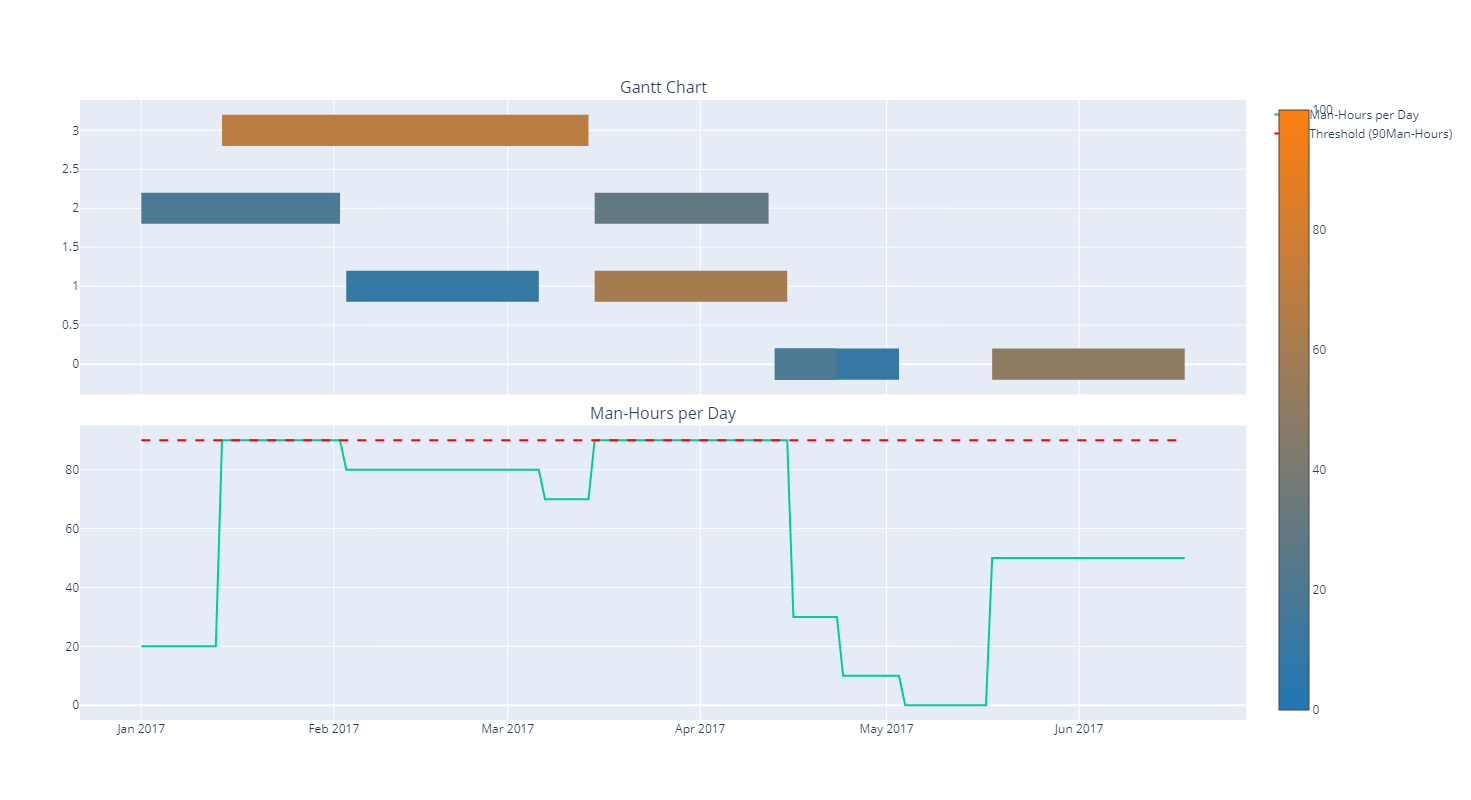

In [76]:
manHoursTreshold = 90
optimized_df = arrange_tasks_greedy(df, manHoursTreshold)
generate_gantt_with_man_hours(optimized_df, manHoursTreshold)

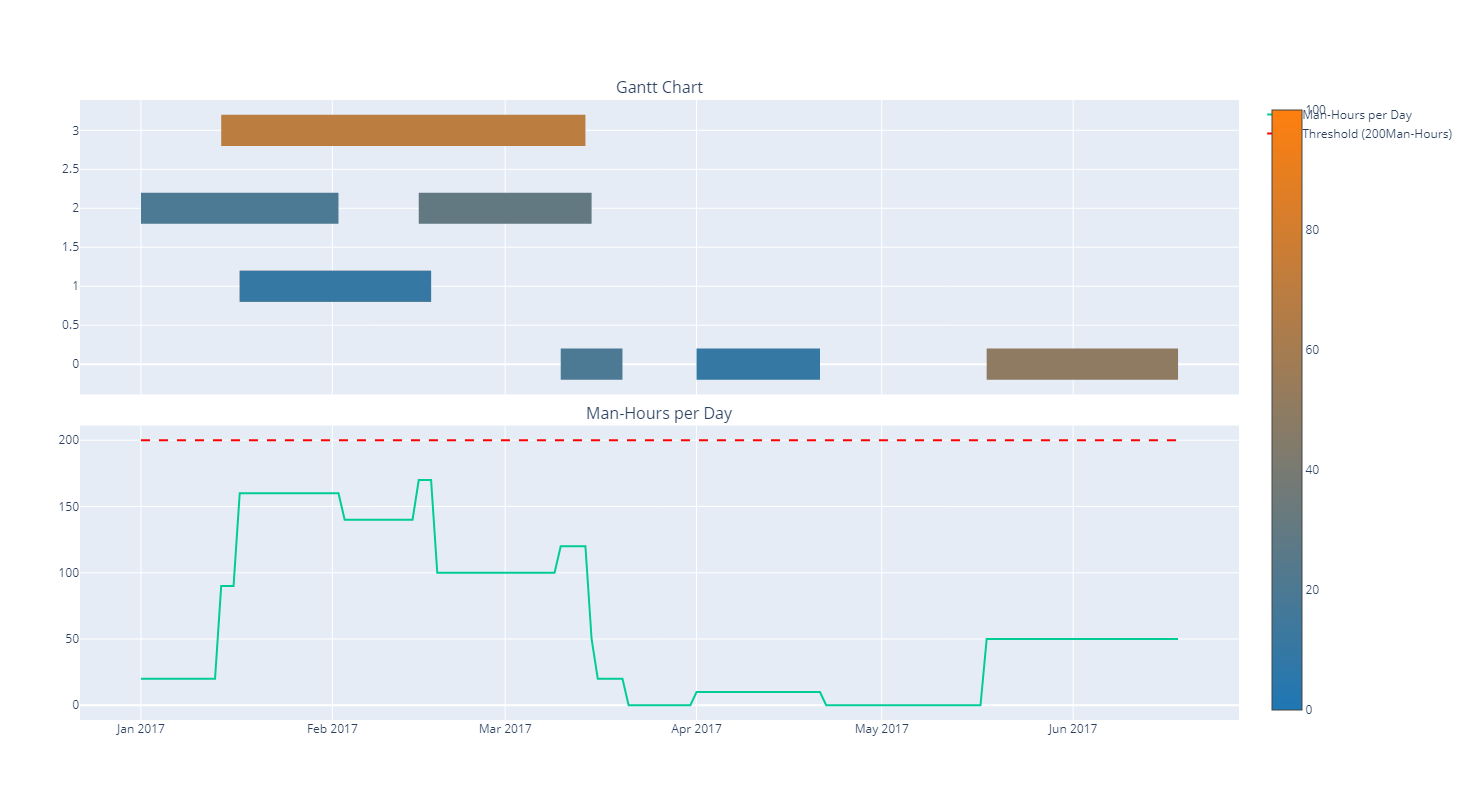

In [77]:
manHoursTreshold = 200
optimized_df = arrange_tasks_greedy(df, manHoursTreshold)
generate_gantt_with_man_hours(optimized_df, manHoursTreshold)

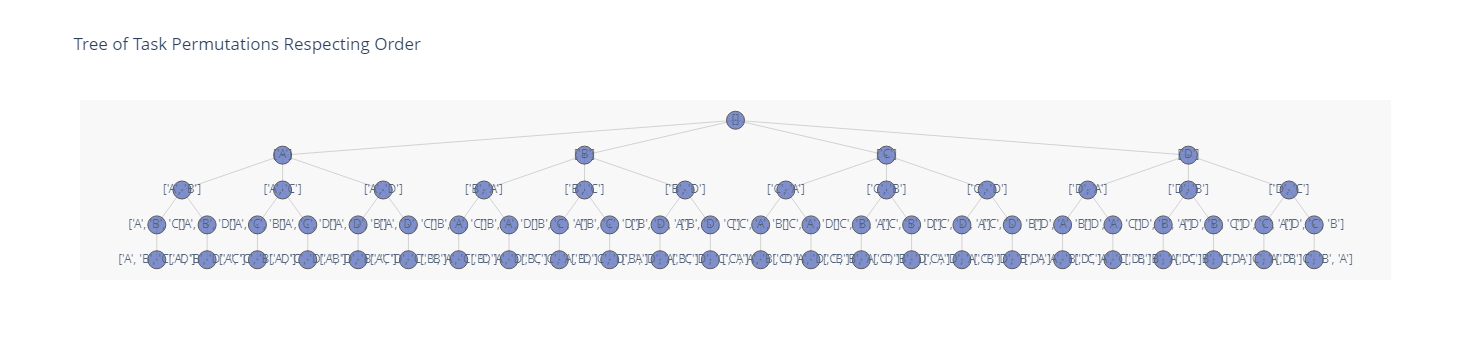

In [101]:
import igraph as ig
import plotly.graph_objects as go
import itertools

# Define the items
items = ['A', 'B', 'C', 'D']

# Create the tree nodes
nodes = [[]]  # Start with the root node, which is an empty list

# Function to generate all sequences respecting order
def generate_sequences(items):
    sequences = [[]]
    for length in range(1, len(items) + 1):
        for seq in itertools.permutations(items, length):
            sequences.append(list(seq))
    return sequences

# Generate all sequences of items respecting order
nodes = generate_sequences(items)

# Create edges
edges = []
for i in range(1, len(nodes)):
    for j in range(i):
        if nodes[j] == nodes[i][:-1]:
            edges.append((j, i))

# Create the graph
G = ig.Graph(edges=edges, directed=True)

# Create a layout for the tree
lay = G.layout('rt')

# Position the nodes in the layout
position = {k: lay[k] for k in range(len(nodes))}
Y = [lay[k][1] for k in range(len(nodes))]
M = max(Y)

# Get edges
es = ig.EdgeSeq(G)
E = [e.tuple for e in G.es]

# Prepare coordinates for nodes and edges
L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M - position[k][1] for k in range(L)]
Xe = []
Ye = []

for edge in E:
    Xe += [position[edge[0]][0], position[edge[1]][0], None]
    Ye += [2*M - position[edge[0]][1], 2*M - position[edge[1]][1], None]

# Create labels for nodes
labels = [str(node) for node in nodes]

# Create Plotly graph
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(x=Xe,
                         y=Ye,
                         mode='lines',
                         line=dict(color='rgb(210,210,210)', width=1),
                         hoverinfo='none'
                         ))

# Add nodes
fig.add_trace(go.Scatter(x=Xn,
                         y=Yn,
                         mode='markers+text',
                         name='',
                         marker=dict(symbol='circle-dot',
                                     size=18,
                                     color='#6175c1',  # node color
                                     line=dict(color='rgb(50,50,50)', width=1)
                                     ),
                         text=labels,
                         hoverinfo='text',
                         opacity=0.8
                         ))

fig.update_layout(title='Tree of Task Permutations Respecting Order',
                  annotations=[],
                  font_size=12,
                  showlegend=False,
                  xaxis=dict(showline=False, zeroline=False, showgrid=False, showticklabels=False),
                  yaxis=dict(showline=False, zeroline=False, showgrid=False, showticklabels=False),
                  hovermode='closest',
                  plot_bgcolor='rgb(248,248,248)'
                  )

fig.show()


